In [29]:
from exif import Image
from datetime import datetime
import cv2
import math
import numpy as np

In [30]:

def get_time(image):
    with open(image, 'rb') as image_file:
        img = Image(image_file)
        time_str = img.get("datetime_original")
        time = datetime.strptime(time_str, '%Y:%m:%d %H:%M:%S')
    return time


In [31]:
print(get_time("imgs\photo_0676.jpg"))

2023-05-08 15:30:56


In [32]:
def get_time_difference(image_1, image_2):
    time_1 = get_time(image_1)
    time_2 = get_time(image_2)
    time_difference = time_2 - time_1
    return time_difference.seconds

In [33]:
print(get_time_difference('imgs/photo_1754.jpg', 'imgs/photo_1755.jpg'))

6


In [34]:
def convert_to_cv(image_1, image_2):
    image_1_cv = cv2.imread(image_1, 0)
    image_2_cv = cv2.imread(image_2, 0)
    return image_1_cv, image_2_cv

In [35]:
def calculate_features(image_1, image_2, feature_number):
    orb = cv2.ORB_create(nfeatures = feature_number)
    keypoints_1, descriptors_1 = orb.detectAndCompute(image_1_cv, None)
    keypoints_2, descriptors_2 = orb.detectAndCompute(image_2_cv, None)
    return keypoints_1, keypoints_2, descriptors_1, descriptors_2

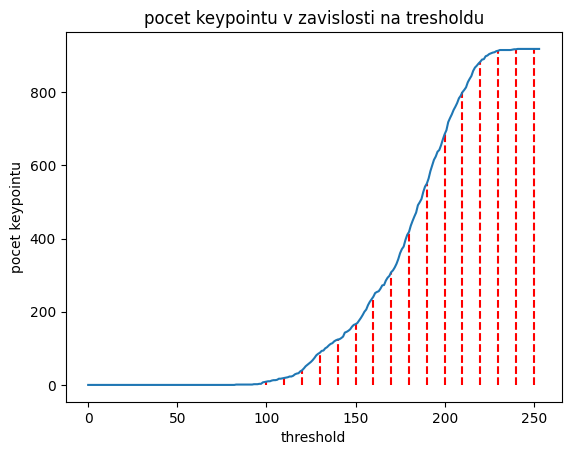

In [36]:
if image_1 != None:
    keypoints_1, keypoints_2, descriptors_1, descriptors_2 = calculate_features(image_1_cv, image_2_cv, 1000)
    #@ zjistime optimalni threshold
    keypoint_volume = []
    for threshold in range(1,255):
        keypoints_1_filtered = []
        #* abych zjistil jakej data threshold
        #* proiteruju skrz keypointy, zjistim jejich svetlost   
        for kp_1 in keypoints_1:
            #zis kam svetlost pixelu na koordinacich stejnych jako jsou koordinace(pozice(pt)) keypointu
            intensity_1 = image_1_cv[int(kp_1.pt[1]), int(kp_1.pt[0])]
            #print(f"svetlost kp_1: {intensity_1}")
            # ponecham jen ty keypointy, ktere jsou dost tmave a jejich descriptory
            if intensity_1 < threshold: 
                keypoints_1_filtered.append(kp_1)
        keypoints_1_filtered = tuple(keypoints_1_filtered)
        #@ veci pro graf
        keypoint_volume.append(len(keypoints_1_filtered))
    #@ GRAF mnoztvi dost tmavych keypointu v zavislosti na thresholdu 
    from matplotlib import pyplot as plt
    plt.title("pocet keypointu v zavislosti na tresholdu")
    plt.ylabel("pocet keypointu")
    plt.xlabel("threshold")
    # Specify the tick positions and labels for the x-axis

    for interval in range(0,255,10):
        plt.vlines(x=interval, ymin=0, ymax=keypoint_volume[interval], colors='red', linestyles='dashed', label=f'Interval {interval}')
    plt.plot(range(len(keypoint_volume)), keypoint_volume)
    plt.show()


In [37]:

#@ filtrovani features tak aby jsme ignorovali mraky(byli features)
def filter_features(threshold, keypoints_1, keypoints_2, descriptors_1, descriptors_2):
    #! BOHUZEL TO ZATIM VYPADA ZE J
    # INE KEYPOINTY NEZ KRAJE MRAKU NEMAME :( ASI SE BUDEM MUSET SMIRIT S TOU MALOU NEPRESNOSTI CO Z TOHO PLYNE
    """
    zjisti svetlost kazdeho keypointu, vyfiltruje keypointy ktere jsou moc svetle(pravdepodobne mraky)

    args: 
    keypoints(tupple): output funkce calculate_features

    returns:
    filtered_features(tupple): features ktere by nemeli byt mraky, nejsou bile
    """

    filtered_keypoints_1 = []
    filtered_keypoints_2 = []
    filtered_descriptors_1 = []
    filtered_descriptors_2 = []
    filtered_indices = []
    #* abych zjistil jakej data threshold
    #* proiteruju skrz keypointy, zjistim jejich svetlost
    for i in range(len(keypoints_1)):
        kp_1 = keypoints_1[i]
        kp_2 = keypoints_2[i]
        #ziskam svetlost pixelu na koordinacich stejnych jako jsou koordinace(pozice(pt)) keypointu
        intensity_1 = image_1_cv[int(kp_1.pt[1]), int(kp_1.pt[0])]
        intensity_2 = image_2_cv[int(kp_2.pt[1]), int(kp_2.pt[0])]
        # ponecham jen ty keypointy, ktere jsou dost tmave a jejich descriptory
        if intensity_1 <= threshold and intensity_2 <= threshold:
            # zjistim indexy tech co chci nechat
            filtered_indices.append(i)
    # dam do listu jen to co je dost tmavy
    filtered_keypoints_1 = [keypoints_1[i] for i in filtered_indices]
    filtered_keypoints_2 = [keypoints_2[i] for i in filtered_indices]
    filtered_descriptors_1 = [descriptors_1[i] for i in filtered_indices]
    filtered_descriptors_2 = [descriptors_2[i] for i in filtered_indices]

    
    return filtered_keypoints_1, filtered_keypoints_2, filtered_descriptors_1, filtered_descriptors_2

In [38]:
def calculate_matches(descriptors_1, descriptors_2):
        # Convert descriptors to NumPy arrays
    descriptors_1 = np.array(descriptors_1, dtype=np.uint8)
    descriptors_2 = np.array(descriptors_2, dtype=np.uint8)

    brute_force = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = brute_force.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

In [39]:
def display_matches(image_1_cv, keypoints_1, image_2_cv, keypoints_2, matches):
    match_img = cv2.drawMatches(image_1_cv, keypoints_1, image_2_cv, keypoints_2, matches[:100], None)
    resize = cv2.resize(match_img, (1600,600), interpolation = cv2.INTER_AREA)
    #!! vsechno vykomentovany pryc vratit
    cv2.imshow('matches', resize)
    #@ zavrit okno klavesou "0"
    cv2.waitKey(0)
    cv2.destroyWindow('matches')

In [40]:
#@ tqdm se musime zbavit pred odevzdanim
from tqdm import tqdm
def find_matching_coordinates(keypoints_1, keypoints_2, matches):
    coordinates_1 = []
    coordinates_2 = []
    for match in tqdm(matches):
        image_1_idx = match.queryIdx
        image_2_idx = match.trainIdx
        (x1,y1) = keypoints_1[image_1_idx].pt
        (x2,y2) = keypoints_2[image_2_idx].pt
        coordinates_1.append((x1,y1))
        coordinates_2.append((x2,y2))
    return coordinates_1, coordinates_2

In [41]:
def calculate_mean_distance(coordinates_1, coordinates_2):
    all_distances = 0
    merged_coordinates = list(zip(coordinates_1, coordinates_2))
    for coordinate in merged_coordinates:
        x_difference = coordinate[0][0] - coordinate[1][0]
        y_difference = coordinate[0][1] - coordinate[1][1]
        distance = math.hypot(x_difference, y_difference)
        all_distances = all_distances + distance
    return all_distances / len(merged_coordinates)

In [42]:
def calculate_speed_in_kmps(feature_distance, GSD, time_difference):
    distance = (feature_distance * GSD)/ 100000
    speed = distance / time_difference
    return speed

In [44]:
image_1 = "imgs/photo_0676.jpg"
image_2 = "imgs/photo_0677.jpg"

show_matches = False
time_difference = get_time_difference(image_1, image_2) # zjisti casovy rozdil
image_1_cv, image_2_cv = convert_to_cv(image_1, image_2) # preformatovani obrazku na opencv objekty
keypoints_1, keypoints_2, descriptors_1, descriptors_2 = calculate_features(image_1_cv, image_2_cv, 1000) # najde keypointy a descriptory
keypoints_celkem = len(keypoints_1)
#@ threshold
threshold = 255 #cim vice keypointu tim presnejsi jsem zjistil takze tak
keypoints_1, keypoints_2, descriptors_1, descriptors_2 = filter_features(threshold, keypoints_1,keypoints_2, descriptors_1, descriptors_2) #* filtered keypoints and descriptors
matches = calculate_matches(descriptors_1, descriptors_2) # najde keypointy co jsou na obou obrazcich
if show_matches: # pokud je potreba vdet keypointy
    match_img = cv2.drawMatches(image_1_cv, keypoints_1, image_2_cv, keypoints_2, matches[:100], None) 
    resize = cv2.resize(match_img, (1600,600), interpolation = cv2.INTER_AREA)
    cv2.imshow('pred_filtrem', resize)
keypoints_po_filtru = len(keypoints_1)
matches = calculate_matches(descriptors_1, descriptors_2) # najde kaypointy co jsou na opou obrazcich
if show_matches: # zase pokud je potreba vydet keypointy
    display_matches(image_1_cv, keypoints_1, image_2_cv, keypoints_2, matches) 
coordinates_1, coordinates_2 = find_matching_coordinates(keypoints_1, keypoints_2, matches)
average_feature_distance = calculate_mean_distance(coordinates_1, coordinates_2)
speed = calculate_speed_in_kmps(average_feature_distance, 12648, time_difference)
speed = speed*1.06396
print(f"threshold: {threshold}")
print(f"keypoints celkem: {keypoints_celkem}")
print(f"keypoints po filtru: {keypoints_po_filtru}")
print(f"prumerna vzdalenost features (km) - {average_feature_distance}")
print(f"rozdil casu (s) - {time_difference}")
print(f"rychlost (km/s) - {speed}")

100%|██████████| 510/510 [00:00<?, ?it/s]

threshold: 255
keypoints celkem: 918
keypoints po filtru: 918
prumerna vzdalenost features (km) - 514.2472423585169
rozdil casu (s) - 9
rychlost (km/s) - 7.6891196635023356
